# Breast Cancer Detector

Detecting Invasive Ductal Carcinoma (IDC) which is the most common subtype of breast cancer using a Convolutional Neural Network. This dataset consists of 162 images that are then divided up into 50x50 chunks. The machine learning model will be fed all of these chunks. 

DATA: https://www.kaggle.com/paultimothymooney/breast-histopathology-images

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation
from keras.layers.normalization import BatchNormalization
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


# Code for Collecting and Processing Data

Since this code has already been ran and the results have been saved to a CSV file. It isn't necessary to keep the code inside of the notebook.

```python
def read_files(path):
    counter = 0
    directory = os.fsencode(path)
    images = np.zeros([1, 2500])
    for file in os.listdir(directory):
            counter += 1
            filename = os.fsdecode(file)
            if filename.endswith('.png'):
                img = cv2.imread(path + filename, 0)
                img = cv2.resize(img, (50,50))        # Resize images to 50x50
                img = img.reshape(-1)                 # Flatten image into 1D array
                images = np.vstack((images, img))     # Stack the images to be put into pandas dataframe
    return images

def process_images(label, folders):
    '''
    Reads files and flattens to 1D arrays.
    '''
    pos_data = []
    neg_data = []
    
    for folder in folders:
        if label == 0:
            path =  'G:/projects/thinkful/Unit 4/data/' + folder + '/0/'
            images = read_files(path)
            neg_data.append(images)

        elif label == 1:
            path = 'G:/projects/thinkful/Unit 4/data/' + folder + '/1/'
            images = read_files(path)
            pos_data.append(images)
            
    if len(pos_data) > 1:
        print(f'Done Processing positive images.')
        return pos_data
    else:
        print(f'Done Processing negative images.')
        return neg_data
    
folders = os.listdir('G:/projects/thinkful/Unit 4/data/')

neg_data = process_images(0, folders) # Collecting processed images into an array
pos_data = process_images(1, folders)


neg_images = np.vstack(neg_data)
pos_images = np.vstack(pos_data)


df_1 = pd.DataFrame(neg_images[1:,:]/255) # Dividng by 255 to normalize the data
df_1['label'] = 0
df_1.to_csv('G:/projects/thinkful/Unit 4/neg_images.csv')

df_2 = pd.DataFrame(pos_images[1:,:]/255) # The first row is ignored as it was used to intialize a numpy array
df_2['label'] = 1
df_2.to_csv('G:/projects/thinkful/Unit 4/pos_images.csv')
```

### Loading Data
By only loading 5000 rows from each CSV file we'll create a balanced dataset.

In [2]:
neg_data = pd.read_csv('G:/projects/thinkful/Unit 4/neg_images.csv', nrows=5000)
pos_data = pd.read_csv('G:/projects/thinkful/Unit 4/pos_images.csv', nrows=5000)

df = pd.concat([neg_data, pos_data])
print(df.shape)
df.head()

(10000, 2502)


,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,label
0,0,0.733333,0.701961,0.760784,0.756863,0.721569,0.733333,0.682353,0.698039,0.760784,...,0.568627,0.498039,0.556863,0.568627,0.615686,0.639216,0.423529,0.721569,0.756863,0
1,1,0.686275,0.705882,0.756863,0.639216,0.635294,0.643137,0.678431,0.776471,0.784314,...,0.964706,0.964706,0.968627,0.972549,0.964706,0.972549,0.960784,0.972549,0.968627,0
2,2,0.964706,0.964706,0.968627,0.972549,0.964706,0.968627,0.980392,0.964706,0.905882,...,0.960784,0.960784,0.964706,0.960784,0.968627,0.960784,0.968627,0.858824,0.572549,0
3,3,0.968627,0.968627,0.968627,0.968627,0.968627,0.968627,0.964706,0.964706,0.976471,...,0.972549,0.964706,0.960784,0.607843,0.552941,0.937255,0.956863,0.941176,0.776471,0
4,4,0.917647,0.952941,0.890196,0.964706,0.972549,0.960784,0.968627,0.968627,0.964706,...,0.490196,0.517647,0.647059,0.780392,0.576471,0.513725,0.592157,0.631373,0.588235,0


### Checking Data

1    5000
0    5000
Name: label, dtype: int64


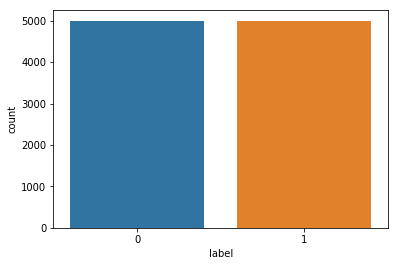

In [3]:
print(df.label.value_counts())
sns.countplot(x=df.label)
plt.show()

# Setting Up Variables and Train/Test Sets

In [4]:
X = df.drop(['label', 'Unnamed: 0'], axis=1).astype('float')
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30) # Creating train/test set

X_train = X_train.values.reshape(-1, 50, 50, 1) # Reshaping to put inside of a keras model
X_test = X_test.values.reshape(-1, 50, 50, 1)

### Previewing Images

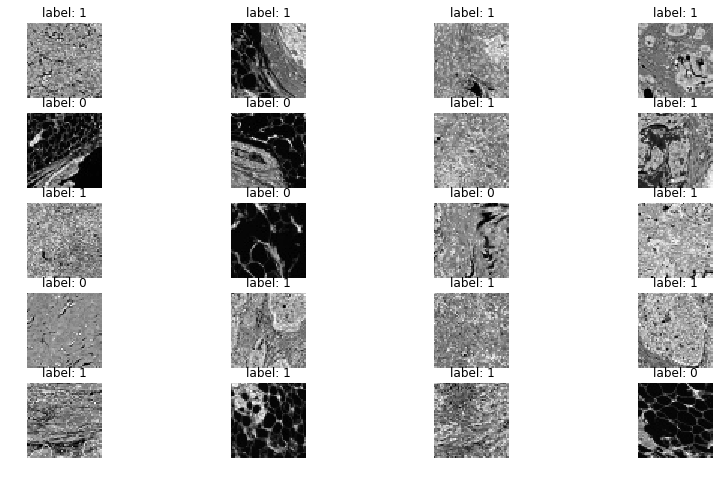

In [5]:
fig = plt.figure(figsize=(14, 8))

cols, rows = 3, 2

ax = []

images_and_labels = list(zip(X_train,  y_train))
for index, (image, label) in enumerate(images_and_labels[:20]):
    plt.subplot(5, 4, index + 1)
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.title('label: %i' % label )
    
plt.show()

In [6]:
n_cats = 1
n_feats = X.shape[1]
print(f'Number of unique labels {n_cats}')
print(f'Number of features {n_feats}')

Number of unique labels 1
Number of features 2500


# Keras Convolutional Neural Net
AlexNet was used as the inspiration for the architecture of the neural network. Since AlexNet was made for a much bigger problem with many more classes I'll be scaling back the dimensions.
![Alex Net](https://cdn-images-1.medium.com/max/1200/1*qyc21qM0oxWEuRaj-XJKcw.png)

In [15]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

#Using the same dimensions as AlexNet
model = Sequential()
# 1st Layer
model.add(Conv2D(filters=24, kernel_size=(5, 5), strides=(4,4), padding='Same', activation='relu', input_shape=(50,50,1)))
# 2nd Layer
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# 3rd Layer
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# 4th Layer
model.add(Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# 5th Layer
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2), padding='Same'))
model.add(BatchNormalization())

model.add(Flatten())
# 1st Fully Connected Layer
model.add(Dense(768, input_shape=(50*50*3,)))
model.add(Activation('relu'))
model.add(Dropout(0.4))
# 2nd Fully Connected Layer
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# 3rd Fully Connected Layer
model.add(Dense(250, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
# Output Layer 
model.add(Dense(2, activation='sigmoid'))


optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.01)

model.compile(optimizer=optimizer , loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
y_train_dummies = pd.get_dummies(y_train) # Creating categorical labels that are one hot encoded for training
y_test_dummies = pd.get_dummies(y_test)
model.fit(X_train, y_train_dummies, epochs=30, batch_size=256)

Epoch 1/30
7000/7000 [==============================] - 2s 310us/step - loss: 0.6159 - acc: 0.7444
Epoch 2/30
7000/7000 [==============================] - 1s 117us/step - loss: 0.5181 - acc: 0.7701
Epoch 3/30
7000/7000 [==============================] - 1s 116us/step - loss: 0.4947 - acc: 0.7786
Epoch 4/30
7000/7000 [==============================] - 1s 116us/step - loss: 0.4629 - acc: 0.7960
Epoch 5/30
7000/7000 [==============================] - 1s 117us/step - loss: 0.4360 - acc: 0.8174
Epoch 6/30
7000/7000 [==============================] - 1s 116us/step - loss: 0.4106 - acc: 0.8281
Epoch 7/30
7000/7000 [==============================] - 1s 117us/step - loss: 0.3860 - acc: 0.8392
Epoch 8/30
7000/7000 [==============================] - 1s 117us/step - loss: 0.3513 - acc: 0.8571
Epoch 9/30
7000/7000 [==============================] - 1s 117us/step - loss: 0.3053 - acc: 0.8795
Epoch 10/30
7000/7000 [==============================] - 1s 119us/step - loss: 0.2600 - acc: 0.9001
Epoch 11/

# Confusion Matrix Results

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1284  206]
 [ 480 1030]]


In [18]:
print(f'Confusion Matrix Accuracy: {(cm[0,0]+cm[1,1])/cm.sum()}')

Confusion Matrix Accuracy: 0.7713333333333333


# Conclusion
There's a strong possibility the model is suffering from some over fitting. Seeing that the predicted accuracy was 99%. However when evaluating the accuracy with a confusion matrix, the model's accuracy was 77%. This is still a relatively good score and doesn't mean the model should be thrown out. The model only missed 206 positive cases of breast cancer, which is roughly 9% of the total predictions. 